
# 03 - Modular Enhancements

This notebook mirrors the Part 3 experiments but keeps the code lightweight by
relying on helper modules in `src/`.


## Imports & shared setup

In [116]:
from pathlib import Path

import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from IPython.display import Markdown, display
from dataclasses import replace, dataclass

from src.config import load_data_config
from src.dataset_pipeline import prepare_tokenised_splits
from src.embeddings import load_torchtext_glove
from src.reports import build_vocabulary_report
from src.models.birnn import BiLSTMClassifier, BiGRUClassifier
from src.models.cnn import CNNTextClassifier
from src.training import (
    RNNExperimentConfig,
    train_rnn_model,
    build_dataloaders_and_vocab,
    run_model_experiment,
    summarise_run,
)
from src.evaluation import evaluate_model, topic_accuracy_table, classification_report_table
from src.plotting import plot_training_curves, latex_set_size, plot_barplot, plot_support_and_f1_by_topic

SEED = 7
sns.set_theme(style="whitegrid")

## Data & embeddings

In [117]:
data_config = load_data_config(Path('configs/data.yaml'))
splits = prepare_tokenised_splits(data_config)
len(splits.train), len(splits.validation), len(splits.test)

(4361, 1091, 500)

In [118]:
vocab_report = build_vocabulary_report(
    tokenised_dataset=splits.train,
    min_freq=data_config.vocabulary_min_freq,
    specials=data_config.vocabulary_specials,
)
embedding_result = load_torchtext_glove(
    vocabulary=vocab_report.vocabulary,
    name='6B',
    dim=100,
    trainable=True,
    random_seed=SEED,
)
embedding_tensor = torch.tensor(embedding_result.matrix, dtype=torch.float32)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchtext/vocab.py:432: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.itos, self.stoi, s

## Shared experiment configuration

In [119]:
base_config = RNNExperimentConfig(
    epochs=15,
    batch_size=64,
    hidden_dim=128,
    num_layers=1,
    dropout=0.3,
    learning_rate=1e-3,
    weight_decay=1e-4,
    grad_clip=1.0,
    pooling='last_hidden',
    optimizer='adam',
    early_stopping_patience=3,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaders, label_to_index = build_dataloaders_and_vocab(base_config, splits, vocab_report.vocabulary)
records = {'rows': [], 'histories': {}, 'evaluations': {}, 'label_maps': {}}

## Baseline RNN

Baseline test accuracy: 0.854

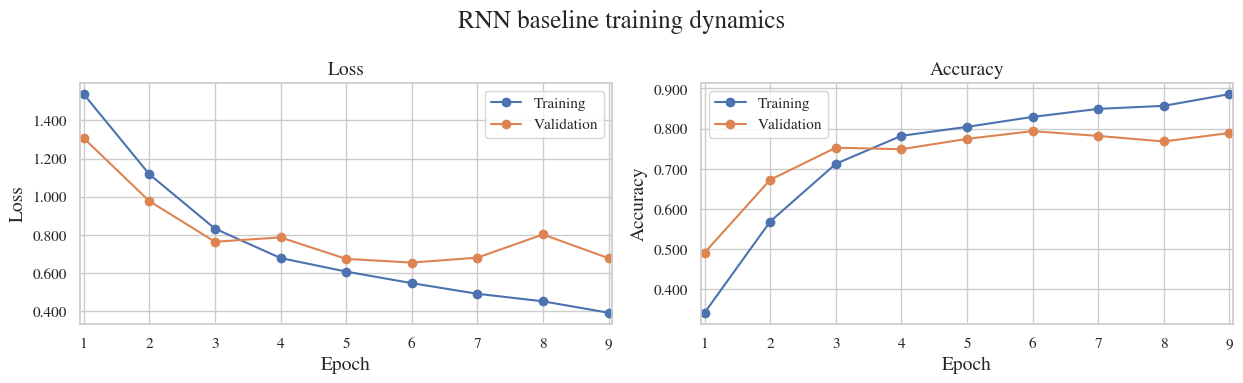

In [120]:
b_hist, b_model, b_label_map, b_loaders = train_rnn_model(
    base_config,
    splits=splits,
    vocabulary=vocab_report.vocabulary,
    embedding_result=embedding_result,
    device=device,
)
b_eval = evaluate_model(b_model, b_loaders.test, device=device)
records['histories']['rnn_baseline'] = b_hist
records['evaluations']['rnn_baseline'] = b_eval
records['label_maps']['rnn_baseline'] = b_label_map
records['rows'].append(summarise_run('rnn_baseline', b_hist, b_eval.accuracy))
plot_training_curves(
    b_hist,
    title='RNN baseline training dynamics',
    output_path=Path('plots/part3_rnn_baseline_curves.png'),
    figure_fraction=1
)
display(Markdown(f"Baseline test accuracy: {b_eval.accuracy:.3f}"))

## biLSTM

biLSTM test accuracy: 0.880

(<Figure size 1259.84x389.313 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

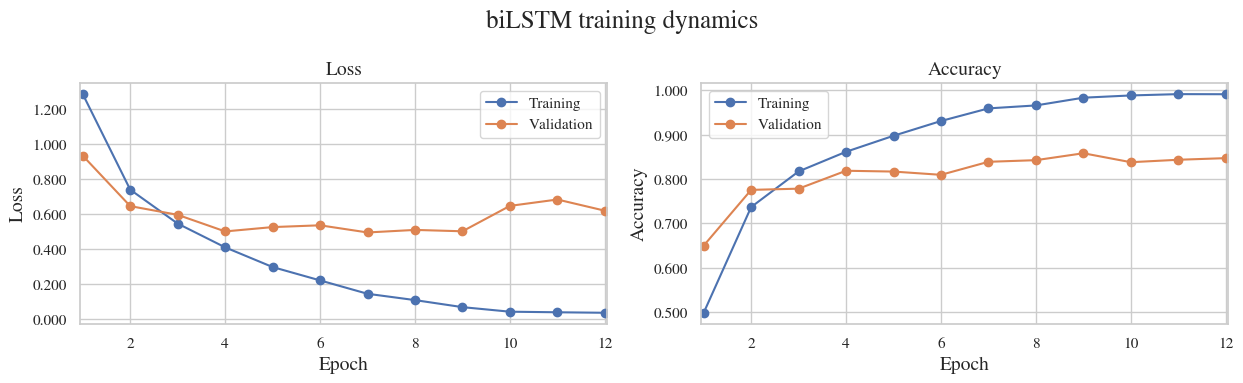

In [121]:
hist_bilstm, model_bilstm, eval_bilstm = run_model_experiment(
    'bilstm',
    model_builder=lambda: BiLSTMClassifier(
        embedding_matrix=embedding_tensor.clone(),
        num_classes=len(label_to_index),
        hidden_dim=base_config.hidden_dim,
        num_layers=base_config.num_layers,
        dropout=base_config.dropout,
    ),
    config=base_config,
    loaders=loaders,
    device=device,
)
records['histories']['bilstm'] = hist_bilstm
records['evaluations']['bilstm'] = eval_bilstm
records['label_maps']['bilstm'] = {idx: label for label, idx in label_to_index.items()}
records['rows'].append(summarise_run('bilstm', hist_bilstm, eval_bilstm.accuracy))
display(Markdown(f"biLSTM test accuracy: {eval_bilstm.accuracy:.3f}"))
plot_training_curves(
    hist_bilstm,
    title='biLSTM training dynamics',
    output_path=Path('plots/part3_bilstm_curves.png'),
    figure_fraction=1
)

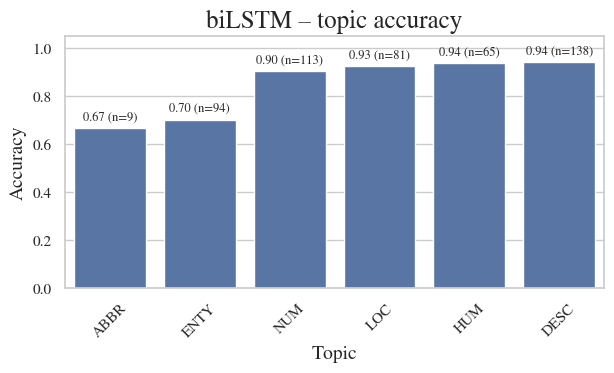

In [122]:
bilstm_topic_df = topic_accuracy_table(eval_bilstm, records['label_maps']['bilstm'])
sorted_bilstm_topics = bilstm_topic_df.sort_values('accuracy')
fig, ax = plot_barplot(
    x=sorted_bilstm_topics['label'],
    y=sorted_bilstm_topics['accuracy'],
    title='biLSTM – topic accuracy',
)
ax.set_xlabel('Topic', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(0, 1.05)
labels = [
    f"{acc:.2f} (n={supp})" for acc, supp in zip(
        sorted_bilstm_topics['accuracy'],
        sorted_bilstm_topics['support'],
    )
]
bar_container = next((container for container in ax.containers if hasattr(container, 'datavalues')), None)
if bar_container is not None:
    for rect, label in zip(bar_container.patches, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.02,
            label,
            ha='center',
            va='bottom',
            fontsize=9,
        )
fig.savefig('plots/part3_bilstm_topic_accuracy.png', dpi=300)
plt.show()


## biGRU

biGRU test accuracy: 0.890

(<Figure size 1259.84x389.313 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

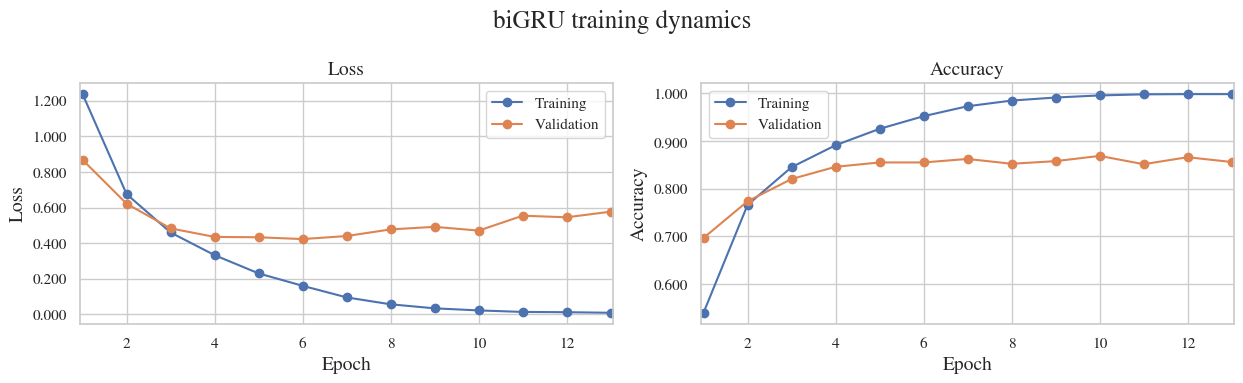

In [123]:
hist_bigru, model_bigru, eval_bigru = run_model_experiment(
    'bigru',
    model_builder=lambda: BiGRUClassifier(
        embedding_matrix=embedding_tensor.clone(),
        num_classes=len(label_to_index),
        hidden_dim=base_config.hidden_dim,
        num_layers=base_config.num_layers,
        dropout=base_config.dropout,
    ),
    config=base_config,
    loaders=loaders,
    device=device,
)
records['histories']['bigru'] = hist_bigru
records['evaluations']['bigru'] = eval_bigru
records['label_maps']['bigru'] = {idx: label for label, idx in label_to_index.items()}
records['rows'].append(summarise_run('bigru', hist_bigru, eval_bigru.accuracy))
display(Markdown(f"biGRU test accuracy: {eval_bigru.accuracy:.3f}"))
plot_training_curves(
    hist_bigru,
    title='biGRU training dynamics',
    output_path=Path('plots/part3_bigru_curves.png'),
    figure_fraction=1

)

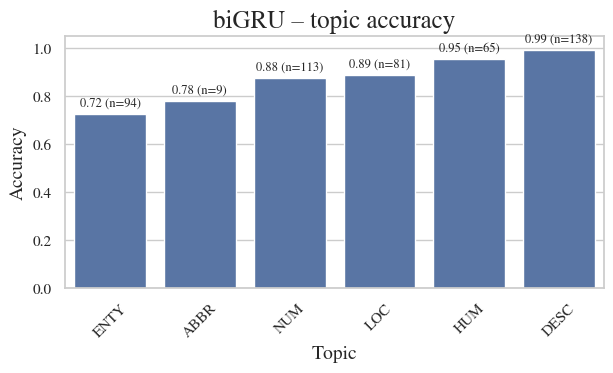

In [124]:
bigru_topic_df = topic_accuracy_table(eval_bigru, records['label_maps']['bigru'])
sorted_bigru_topics = bigru_topic_df.sort_values('accuracy')
fig, ax = plot_barplot(
    x=sorted_bigru_topics['label'],
    y=sorted_bigru_topics['accuracy'],
    title='biGRU – topic accuracy',
)
ax.set_xlabel('Topic', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(0, 1.05)
labels = [
    f"{acc:.2f} (n={supp})" for acc, supp in zip(
        sorted_bigru_topics['accuracy'],
        sorted_bigru_topics['support'],
    )
]
bar_container = next((container for container in ax.containers if hasattr(container, 'datavalues')), None)
if bar_container is not None:
    for rect, label in zip(bar_container.patches, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.02,
            label,
            ha='center',
            va='bottom',
            fontsize=9,
        )
fig.savefig('plots/part3_bigru_topic_accuracy.png', dpi=300)
plt.show()


## CNN

CNN test accuracy: 0.902

(<Figure size 1259.84x389.313 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

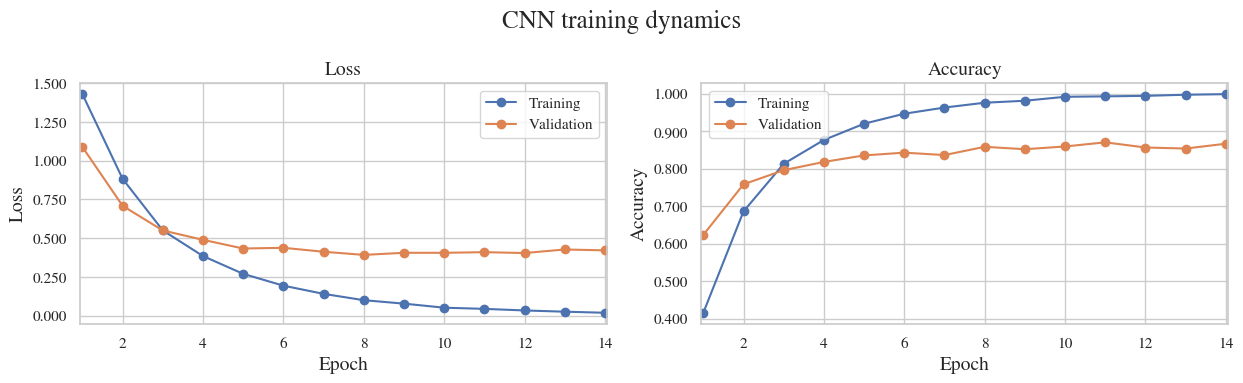

In [125]:
cnn_config = replace(base_config, dropout=0.5, weight_decay=0.0, grad_clip=0.0)
hist_cnn, model_cnn, eval_cnn = run_model_experiment(
    'cnn',
    model_builder=lambda: CNNTextClassifier(
        embedding_matrix=embedding_tensor.clone(),
        num_classes=len(label_to_index),
        dropout=cnn_config.dropout,
    ),
    config=cnn_config,
    loaders=loaders,
    device=device,
)
records['histories']['cnn'] = hist_cnn
records['evaluations']['cnn'] = eval_cnn
records['label_maps']['cnn'] = {idx: label for label, idx in label_to_index.items()}
records['rows'].append(summarise_run('cnn', hist_cnn, eval_cnn.accuracy))
display(Markdown(f"CNN test accuracy: {eval_cnn.accuracy:.3f}"))
plot_training_curves(
    hist_cnn,
    title='CNN training dynamics',
    output_path=Path('plots/part3_cnn_curves.png'),
    figure_fraction=1
    
)

## Further Model Improvement

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/functional.py:1381: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


RCNN test accuracy: **0.932**

(<Figure size 1259.84x389.313 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

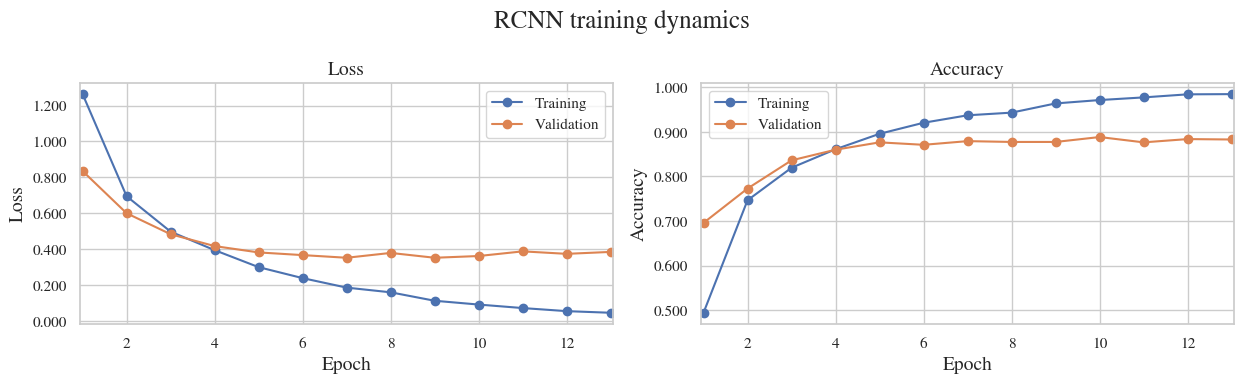

In [126]:
from src.models.rcnn import RCNNTextClassifier

hist_rcnn, model_rcnn, eval_rcnn = run_model_experiment(
    'rcnn',
    model_builder=lambda: RCNNTextClassifier(
        embedding_matrix=embedding_tensor.clone(),
        num_classes=len(label_to_index),
        hidden_dim=base_config.hidden_dim,
        num_layers=base_config.num_layers,
        dropout=base_config.dropout,
        padding_idx=0,
        multisample_dropout=4,
    ),
    config=base_config,
    loaders=loaders,
    device=device,
)

records['histories']['rcnn'] = hist_rcnn
records['evaluations']['rcnn'] = eval_rcnn
records['label_maps']['rcnn'] = {idx: label for label, idx in label_to_index.items()}
records['rows'].append(summarise_run('rcnn', hist_rcnn, eval_rcnn.accuracy))

display(Markdown(f"RCNN test accuracy: **{eval_rcnn.accuracy:.3f}**"))
plot_training_curves(
    hist_rcnn,
    title='RCNN training dynamics',
    output_path=Path('plots/part3_3_rcnn_curves.png'),
    figure_fraction=1
)


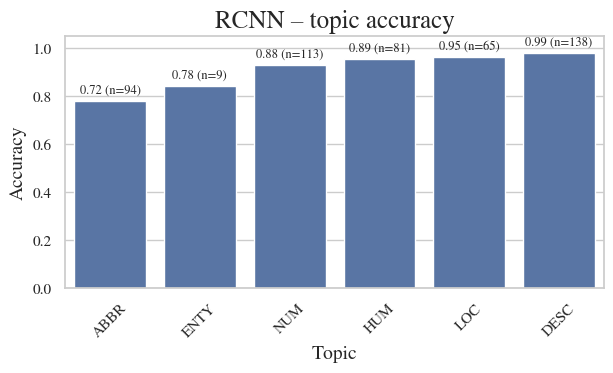

In [129]:
rcnn_topic_df = topic_accuracy_table(eval_rcnn, records['label_maps']['rcnn'])
sorted_rcnn_topics = rcnn_topic_df.sort_values('accuracy')
fig, ax = plot_barplot(
    x=sorted_rcnn_topics['label'],
    y=sorted_rcnn_topics['accuracy'],
    title='RCNN – topic accuracy',
)
ax.set_xlabel('Topic', fontsize=14) 
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(0, 1.05)
labels = [
    f"{acc:.2f} (n={supp})" for acc, supp in zip(
        sorted_bigru_topics['accuracy'],
        sorted_bigru_topics['support'],
    )
]
bar_container = next((container for container in ax.containers if hasattr(container, 'datavalues')), None)
if bar_container is not None:   
    for rect, label in zip(bar_container.patches, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.02,
            label,
            ha='center',
            va='bottom',
            fontsize=9,
        )
fig.savefig('plots/part3_rcnn_topic_accuracy.png', dpi=300)
plt.show()

## Summary & comparison

,best_epoch,val_accuracy,test_accuracy
name,,,
rcnn,10,0.888176,0.932
cnn,11,0.869844,0.902
bigru,10,0.868928,0.890
bilstm,9,0.857929,0.880
rnn_baseline,6,0.793767,0.854


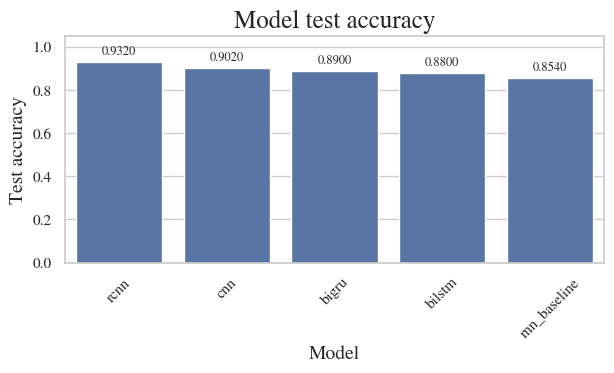

Best model: **rcnn** (test accuracy 0.932)

,label,accuracy,support
0,ABBR,0.777778,9
2,ENTY,0.840426,94
5,NUM,0.929204,113
3,HUM,0.953846,65
4,LOC,0.962963,81
1,DESC,0.978261,138


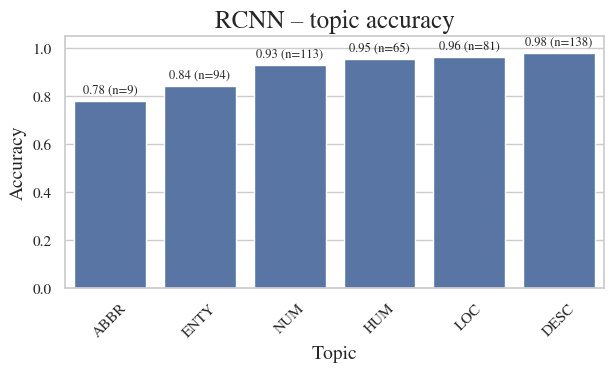

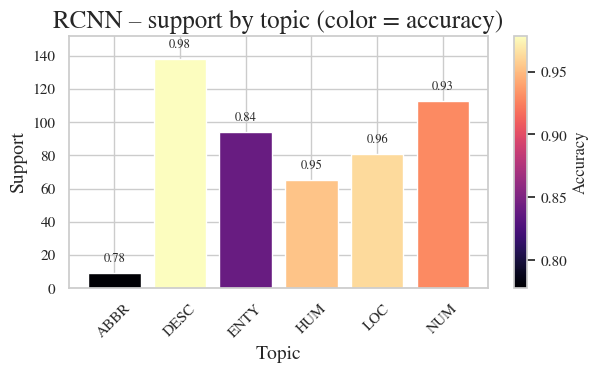

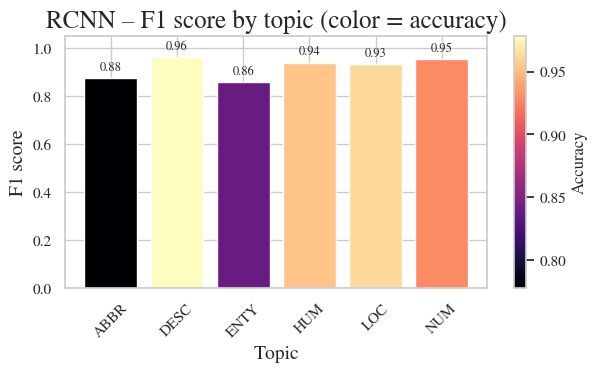

,precision,recall,f1-score,support
accuracy,0.932000,0.932000,0.932000,0.932
macro avg,0.939249,0.907079,0.920437,500.000
weighted avg,0.932586,0.932000,0.931558,500.000


In [128]:
comparison_df = pd.DataFrame(records['rows']).set_index('name').sort_values('test_accuracy', ascending=False)
display(comparison_df)

fig, ax = plot_barplot(
    x=comparison_df.index,
    y=comparison_df['test_accuracy'],
    title='Model test accuracy',
)
ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('Test accuracy', fontsize=14)
ax.set_ylim(0, 1.05)
label_values = [f"{score:.4f}" for score in comparison_df['test_accuracy']]
bar_container = next((container for container in ax.containers if hasattr(container, 'datavalues')), None)
if bar_container is not None:
    for rect, label in zip(bar_container.patches, label_values):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.02,
            label,
            ha='center',
            va='bottom',
            fontsize=9,
        )
plt.show()

best_row = comparison_df.iloc[0]
best_name = best_row.name
best_eval = records['evaluations'][best_name]
best_history = records['histories'][best_name]
best_label_map = records['label_maps'][best_name]
best_accuracy = float(best_row['test_accuracy'])
display(Markdown(f"Best model: **{best_name}** (test accuracy {best_accuracy:.3f})"))

best_topic_df = topic_accuracy_table(best_eval, best_label_map)
sorted_best_topics = best_topic_df.sort_values('accuracy')
display(sorted_best_topics)

fig, ax = plot_barplot(
    x=sorted_best_topics['label'],
    y=sorted_best_topics['accuracy'],
    title=f"{best_name.upper()} – topic accuracy",
)
ax.set_xlabel('Topic', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(0, 1.05)
topic_labels = [
    f"{acc:.2f} (n={supp})" for acc, supp in zip(
        sorted_best_topics['accuracy'],
        sorted_best_topics['support'],
    )
]
bar_container = next((container for container in ax.containers if hasattr(container, 'datavalues')), None)
if bar_container is not None:
    for rect, label in zip(bar_container.patches, topic_labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.02,
            label,
            ha='center',
            va='bottom',
            fontsize=9,
        )
fig.savefig(f"plots/part3_{best_name}_topic_accuracy.png", dpi=300)
plt.show()

best_report_df = classification_report_table(best_eval, best_label_map)
label_rows = best_report_df.loc[~best_report_df.index.isin(['accuracy', 'macro avg', 'weighted avg', 'micro avg'])].copy()
if 'accuracy' not in label_rows.columns:
    label_rows['accuracy'] = label_rows.get('recall', 0.0)

plot_support_and_f1_by_topic(
    label_rows,
    support_title=f"{best_name.upper()} – support by topic (color = accuracy)",
    f1_title=f"{best_name.upper()} – F1 score by topic (color = accuracy)",
    xlabel='Topic',
    support_ylabel='Support',
    f1_ylabel='F1 score',
    support_output_path=f"plots/part3_{best_name}_classification_support.png",
    f1_output_path=f"plots/part3_{best_name}_classification_f1.png",
)

averages_df = best_report_df.loc[
    ['accuracy', 'macro avg', 'weighted avg'],
    [col for col in best_report_df.columns if col in ['precision', 'recall', 'f1-score', 'support']],
]
display(averages_df)
